In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# In cocoeval.py to get the thresholds of IoU @0.2 according to the paper
#Line 461
#stats[1] = _summarize(1, iouThr=.2, maxDets=self.params.maxDets[2])
#Line 466
#stats[6] = _summarize(0, iouThr=.2, maxDets=self.params.maxDets[2])
#Line 506
#self.iouThrs = np.linspace(.2, 1, int(np.round((1 - .2) / .05)) + 1, endpoint=True)

In [1]:
import pycocotools
import os
dir = r'/content/drive/MyDrive/Fruit Detection DL/pytorch object detection/vision/references/detection'
os.chdir(dir)

In [2]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import PIL
from PIL import Image, ImageDraw
import pandas as pd
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from engine import train_one_epoch, evaluate
import utils
import os,sys
import transforms as T
import original_transforms as T2

In [3]:
def parse_one_annot(path_to_data_file, filename):
    data = pd.read_csv(path_to_data_file)
    boxes_array = data[data["filename"] == filename][["x", "y",        
   "dx_new", "dy_new"]].values
   
    return boxes_array

In [4]:
# Define the datset class. This loads the path to the images and path to the csv file with dimensions of bounding boxes
class FruitDataset(torch.utils.data.Dataset):
    def __init__(self, root, data_file, transforms=None):
        
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(self.root))
        self.path_to_data_file = data_file     
       

    def __getitem__(self, idx):
        
        # load images and bounding boxes
          
        img_path = os.path.join(self.root, self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        draw = ImageDraw.Draw(img)
        box_list = parse_one_annot(self.path_to_data_file,self.imgs[idx][:-4])
        boxes = torch.as_tensor(box_list, dtype=torch.float32)
        num_objs = len(box_list)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
         
        return img, target  
    
    def __len__(self):
        return len(self.imgs)
             

In [5]:
dataset = FruitDataset(root= r"/content/drive/MyDrive/Fruit Detection DL/mangoes/train_images",
data_file= r"/content/drive/MyDrive/Fruit Detection DL/mangoes/combined_train/combined_csv.csv")
dataset.__getitem__(1)

(<PIL.Image.Image image mode=RGB size=500x500 at 0x7F68455E6F10>,
 {'area': tensor([2223.9680, 2223.9680, 2223.9680, 2223.9680, 1362.9443,  885.2867,
          1296.1459]),
  'boxes': tensor([[273.0000, 344.0000, 320.1590, 391.1590],
          [248.0000, 356.0000, 295.1590, 403.1590],
          [373.0000, 395.0000, 420.1590, 442.1590],
          [391.0000, 418.0000, 438.1590, 465.1590],
          [332.6316, 381.5789, 364.6316, 424.1710],
          [327.3684, 267.3684, 355.8804, 298.4180],
          [344.7368, 242.1053, 376.1000, 283.4323]]),
  'image_id': tensor([1]),
  'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0]),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1])})

In [7]:
def get_model(num_classes):
    
    #Selecting the pretrained VGG16 faster-RCNN as the backbone model
    backbone = torchvision.models.vgg16(pretrained=True).features
    backbone.out_channels = 512

    anchor_generator = AnchorGenerator(sizes=(( 64, 128,256),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))
    
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=["0"],
                                                output_size=7,
                                                sampling_ratio=2)
    
    model = FasterRCNN(backbone,num_classes=2,
                      rpn_anchor_generator=anchor_generator,
                      box_roi_pool=roi_pooler)

    return model

In [18]:
def get_transform(train):    
    
    transform_list = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transform_list.append(T.ToTensor())
    if train:
      #Flip transform- images are flipped with 0.5 probability
      transform_list.append(T2.RandomHorizontalFlip(0.5))
      #Scale transform to 300x300
      transform_list.append(T.Resize(size = 300))

      #Convert images to grayscale with a probability of 0.2
      #transform_list.append(T.RandomGrayscale(0.2))
               
    return T.Compose(transform_list)

In [9]:
dataset = FruitDataset(root= r"/content/drive/MyDrive/Fruit Detection DL/mangoes/train_images",
data_file= r"/content/drive/MyDrive/Fruit Detection DL/mangoes/combined_train/combined_csv.csv",transforms = get_transform(train=True))

dataset_test = FruitDataset(root= r"/content/drive/MyDrive/Fruit Detection DL/mangoes/test_images",
          data_file= r"/content/drive/MyDrive/Fruit Detection DL/mangoes/combined_test/combined_test_csv.csv",
               transforms = get_transform(train=False))
#Random seed value
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

#Choose a subset from the training dataset
dataset_subset = torch.utils.data.Subset(dataset,indices[:500])

data_loader = torch.utils.data.DataLoader(dataset_subset, batch_size=1, shuffle=True, num_workers=0,
                                          collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
         dataset_test, batch_size=1, shuffle=False, num_workers=0,
         collate_fn=utils.collate_fn)

print("Train dataset: ", len(data_loader), " \nTest dataset length",len(dataset_subset_test))
#dataset.__getitem__(1)

Train dataset:  500  
Test dataset length 250


In [ ]:
#Check if GPU is available
torch.cuda.is_available()

True

In [ ]:
device = torch.device('cuda:0')
# Our dataset has two classes only - mango and not mango
num_classes = 2
# Get the model using our helper function
model = get_model(num_classes)
# Move model to the right device
model.to(device)
# Construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# A learning rate scheduler which decreases the learning rate by # 10x every 5 epochs. Change this value based on the dataset size

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=5,gamma=0.1)

In [ ]:
# Number of epochs to train for
num_epochs = 20

for epoch in range(num_epochs):

   # train for one epoch, printing every 500 iterations
    torch.cuda.empty_cache()
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=500)
    # update the learning rate
    lr_scheduler.step()
    
    # Save the model every 2 epochs
    if (epoch%2)==0:
      torch.save(model.state_dict(), r"/content/drive/MyDrive/Fruit Detection DL/pytorch object detection/fruit/vgg16_flip_scale_size500")
    
    # Evaluate the model on test set every 2 epochs to check precision and recall
    if (epoch%2)==0:
      evaluate(model, data_loader_test, device=device)

#Save the model after training
torch.save(model.state_dict(), r"/content/drive/MyDrive/Fruit Detection DL/pytorch object detection/fruit/vgg16_flip_scale_size500")
# Evaluate on the test dataset after training
evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:365: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Epoch: [0]  [  0/500]  eta: 0:03:02  lr: 0.000015  loss: 1.4734 (1.4734)  loss_classifier: 0.7152 (0.7152)  loss_box_reg: 0.0283 (0.0283)  loss_objectness: 0.6976 (0.6976)  loss_rpn_box_reg: 0.0323 (0.0323)  time: 0.3656  data: 0.0632  max mem: 1689
Epoch: [0]  [499/500]  eta: 0:00:00  lr: 0.005000  loss: 0.0994 (0.3242)  loss_classifier: 0.0414 (0.1289)  loss_box_reg: 0.0297 (0.0360)  loss_objectness: 0.0274 (0.1463)  loss_rpn_box_reg: 0.0038 (0.0131)  time: 0.3087  data: 0.0451  max mem: 1690
Epoch: [0] Total time: 0:02:35 (0.3104 s / it)
creating index...
index created!
Test:  [  0/250]  eta: 0:00:45  model_time: 0.1509 (0.1509)  evaluator_time: 0.0023 (0.0023)  time: 0.1822  data: 0.0281  max mem: 1690
Test:  [100/250]  eta: 0:00:21  model_time: 0.0952 (0.0954)  evaluator_time: 0.0011 (0.0128)  time: 0.1366  data: 0.0321  max mem: 1690
Test:  [200/250]  eta: 0:00:06  model_time: 0.0982 (0.0962)  evaluator_time: 0.0013 (0.0109)  time: 0.1372  data: 0.0323  max mem: 1690
Test:  [249/

In [12]:
#Load a saved model
loaded_model = get_model(num_classes = 2)
loaded_model.load_state_dict(torch.load(r"/content/drive/MyDrive/Fruit Detection DL/pytorch object detection/fruit/vgg16_gs_full"))

<All keys matched successfully>

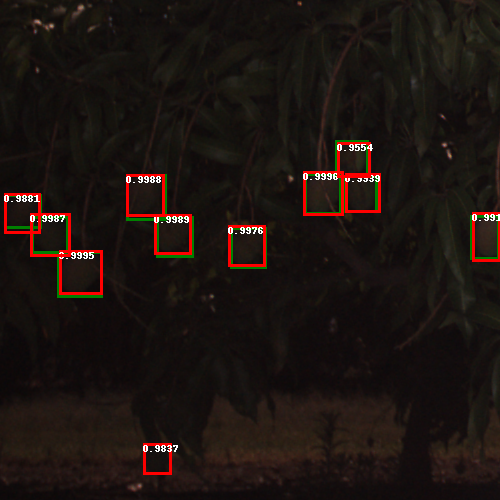

In [19]:
idx = 200
img, _ = dataset_test[idx]
label_boxes = np.array(dataset_test[idx][1]["boxes"])
#put the model in evaluation mode
loaded_model.eval()
with torch.no_grad():
   prediction = loaded_model([img])
image = Image.fromarray(img.mul(255).permute(1, 2,0).byte().numpy())
draw = ImageDraw.Draw(image)
# Draw groundtruth box in Green
for elem in range(len(label_boxes)):
   draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),
   (label_boxes[elem][2], label_boxes[elem][3])], 
   outline ="green", width =3)

#Draw prediction box in Red
for element in range(len(prediction[0]["boxes"])):
   boxes = prediction[0]["boxes"][element].cpu().numpy()
   score = np.round(prediction[0]["scores"][element].cpu().numpy(),
                    decimals= 4)
   
   #Drawing prediction boxes above a certain confidence threshold
   if score > 0.8:
      draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
      outline ="red", width =3)
      draw.text((boxes[0], boxes[1]), text = str(score))
image